# Outline

1.   Basic motivation of hyperparameter tuning
2.   Integrating Google colab with a local runtime (config in Google colab, Browser, Jupyter notebook)
3.   Installing MLFlow and basic use case
4.   Logging parameters, metrics with MLFlow
5.   Logging image artifacts with MLFlow
6.   Logging PyTorch models with MLFlow and loading them



In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision import datasets, transforms

import torch.nn as nn
import torch.optim as optim
import seaborn as sns

In [0]:
import mlflow
import mlflow.pytorch

# Params

In [0]:
class Params(object):
    def __init__(self, batch_size, epochs, seed, log_interval):
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.log_interval = log_interval

args = Params(256, 4, 0, 20)

# Dataset

In [0]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST('../data', train=True, download=True, 
                         transform=transform)

test_set = datasets.MNIST('../data', train=False, download=True, 
                         transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False)

# Model

In [0]:
class Model(nn.Module):
    def __init__(self, nH = 32): 
        super(Model, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, nH),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(nH, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [0]:
def train(epoch):
    
    model.train()
    
    for batch_id, data in enumerate(train_loader):
        inputs, labels = data
        
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if batch_id % args.log_interval == 0:
            pos = epoch * len(train_loader) + batch_id
            mlflow.log_metric('train_loss', loss.data.item()/len(inputs)*1000)
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
                epoch, batch_id * len(inputs), len(train_loader.dataset),
                100. * batch_id / len(train_loader), loss.data.item()))

In [0]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    confusion_matrix = np.zeros([10, 10])
    
    with torch.no_grad():
        
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_loss += loss_fn(outputs, labels).data.item()
            pred = outputs.data.max(1)[1]
            correct += pred.eq(labels.data).sum().item()
            
            for x, y in zip(pred.numpy(), labels.numpy()):
                confusion_matrix[x][y] += 1
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100.0 * correct / len(test_loader.dataset)
        
        pos = (epoch + 1) * len(train_loader)
        mlflow.log_metric('test_loss', test_loss*1000)
        mlflow.log_metric('test_accuracy', test_accuracy)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset), test_accuracy))
              
        if epoch == args.epochs:
            classes = np.arange(10)
            fig, ax = plt.subplots()
            im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            ax.figure.colorbar(im, ax=ax)
            ax.set(xticks=np.arange(confusion_matrix.shape[1]),
                       yticks=np.arange(confusion_matrix.shape[0]),
                       xticklabels=classes, yticklabels=classes,
                       ylabel='True label',
                       xlabel='Predicted label',
                       title='Epoch %d' % epoch)
            thresh = confusion_matrix.max() / 2.
            for i in range(confusion_matrix.shape[0]):
                for j in range(confusion_matrix.shape[1]):
                    ax.text(j, i, int(confusion_matrix[i, j]),
                            ha="center", va="center",
                            color="white" if confusion_matrix[i, j] > thresh else "black")
              
            fig.tight_layout()
              
            image_path = 'images/%s.png' % (expt_id)
            plt.savefig(image_path)
            mlflow.log_artifact(image_path)
            

# Hyperparameter tuning loop


LR = 0.01, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.985
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.514
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.308
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.513
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.302
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.335
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.302
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.295
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.346
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.223
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.323

Test set: Average loss: 0.0010, Accuracy: 9235/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.282


/usr/local/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.216
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.297
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.256
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.271
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.231
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.240
Train Epoch: 2 [35840/60000 (60%)]	Loss: 0.205
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.371
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.263
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.195
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.242

Test set: Average loss: 0.0008, Accuracy: 9387/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.197
Train Epoch: 3 [5120/60000 (9%)]	Loss: 0.146
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.156
Train Epoch: 3 [15360/60000 (26%)]	Loss: 0.145
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.167
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.177
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.147
Train Epoch: 3 [35840/60000 (60%)]	Loss: 0.184
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.205
Train Ep

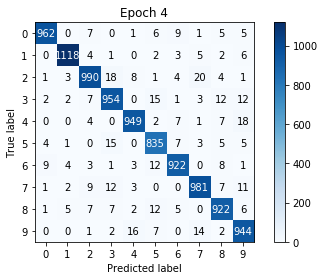

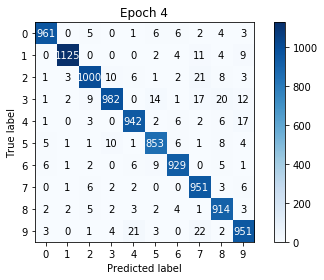

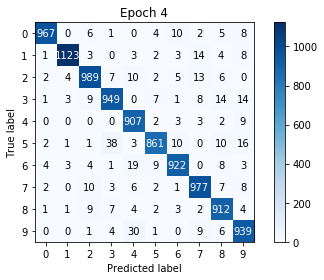

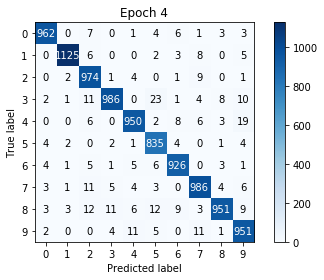

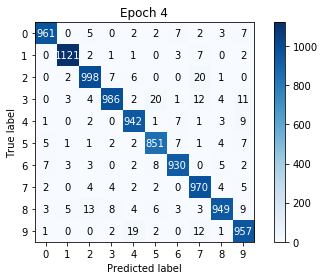

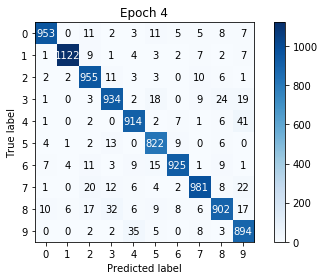

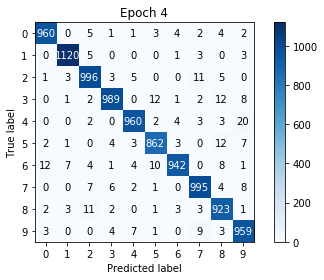

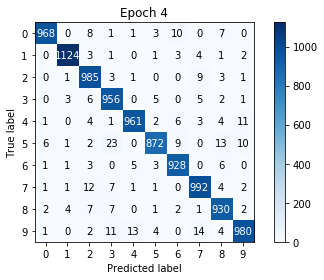

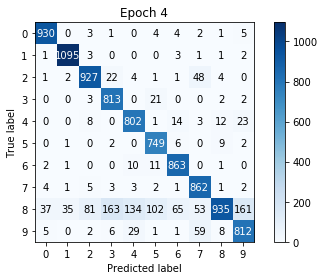

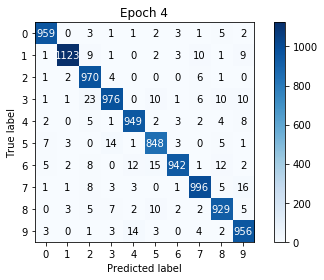

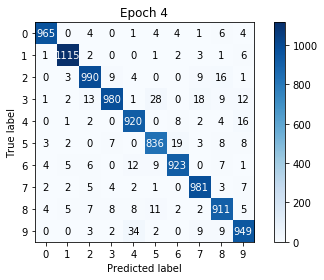

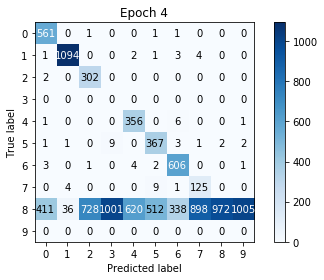

In [13]:
# expt_id = mlflow.create_experiment('Fixed nH')

mlflow.set_experiment('Fixed nH')

for lr in [0.01, 0.02, 0.05, 0.1]:
    for momentum in [0.9, 0.95, 0.99]:
        for hidden_nodes in [48]:
        
            expt_id = '%d_%d_%d' % (int(lr*100), int(momentum*100), hidden_nodes)

            print('\nLR = %.2f, Momentum = %.2f, Hidden nodes = %d\n' % (lr, momentum, hidden_nodes))

            model = Model(hidden_nodes)

            loss_fn = nn.CrossEntropyLoss()
            opt = optim.SGD(model.parameters(), lr=lr, momentum = momentum)

            with mlflow.start_run() as run:  
                for key, value in vars(args).items():
                    mlflow.log_param(key, value)
                mlflow.log_param('lr', lr)
                mlflow.log_param('momentum', momentum)
                mlflow.log_param('hidden_nodes', hidden_nodes)

                for epoch in range(1, args.epochs + 1):
                    train(epoch)
                    test(epoch)

                mlflow.pytorch.log_model(model, "models")

# Loading and visualising a model

In [0]:
model_load = mlflow.pytorch.load_model('models', run_id="9a5e902876654a88b9876e481aa37b27")

In [15]:
print(model_load)

Model(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=10, bias=True)
  )
)


In [0]:
weight_layer0 = list(model_load.parameters())[0].data.numpy()

In [17]:
print(weight_layer0.shape)

(48, 784)


[]

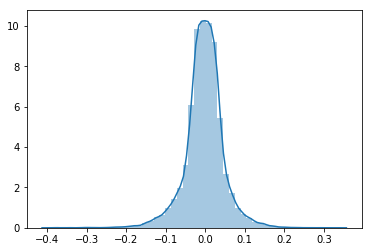

In [18]:
sns.distplot(weight_layer0.ravel())
plt.plot()

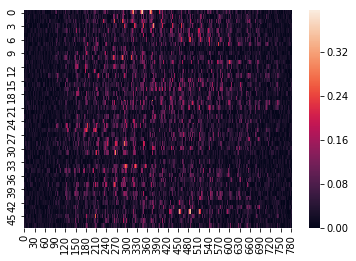

In [19]:
sns.heatmap(np.abs(weight_layer0))
plt.show()

In [0]:
weight_layer1 = list(model_load.parameters())[2].data.numpy()

In [21]:
weight_layer1.shape

(10, 48)

[]

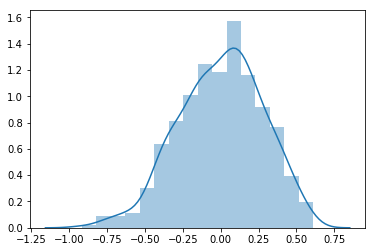

In [22]:
sns.distplot(weight_layer1.ravel())
plt.plot()

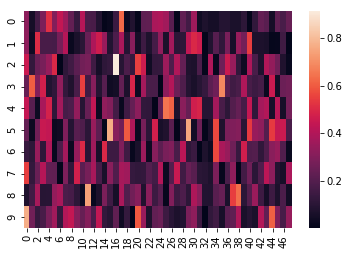

In [23]:
sns.heatmap(np.abs(weight_layer1))
plt.show()

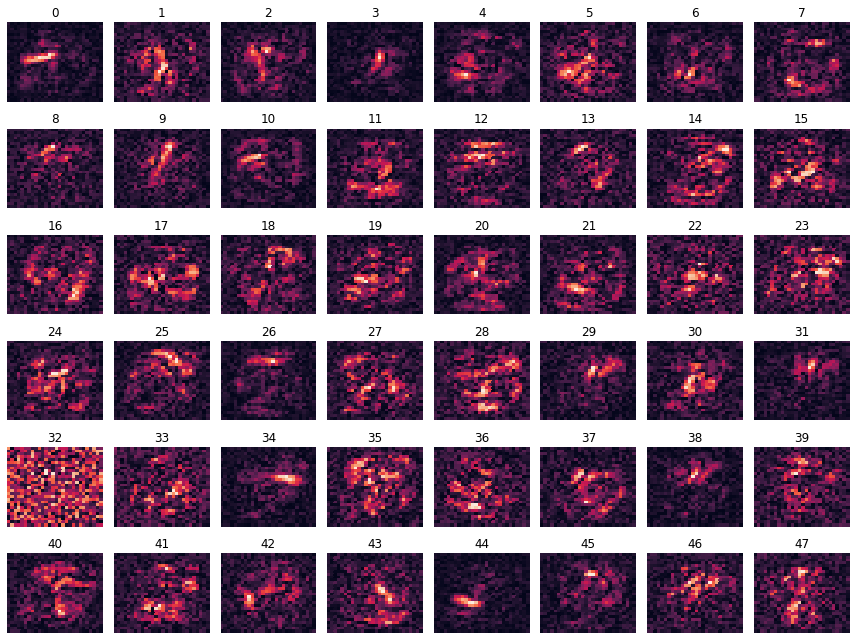

In [46]:
nrows = 6
ncols = 8
fig = plt.figure(figsize=(1.5*ncols, 1.5*nrows))

for i in np.arange(48): 
    ax1 = fig.add_subplot(nrows, ncols, i+1)
    sns.heatmap(np.abs((weight_layer0[i, 0:784]).reshape(28, 28)), ax = ax1, cbar=False)
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_title(i)
plt.tight_layout()
plt.show()